### **一、以Lena为原始图像，通过OpenCV实现平均滤波，高斯滤波及中值滤波，比较滤波结果**

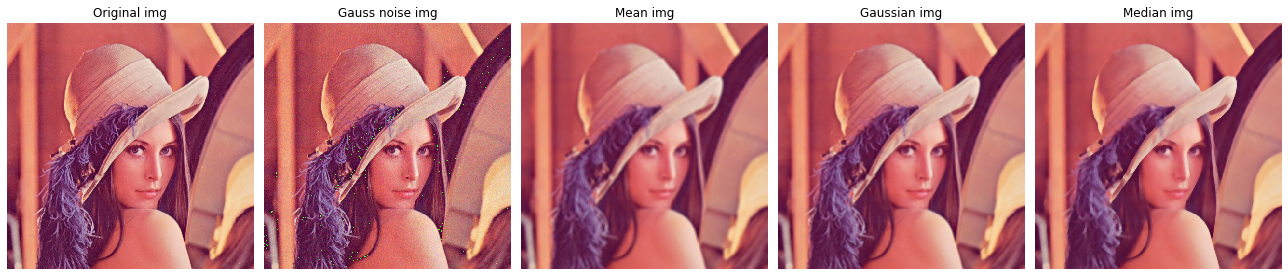

In [31]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

lena = './screenshot/lena.png'
img = cv.imread(lena)

# 图片加入彩色噪声
def get_gauss_noise(image, mean=0, var=0.001):
    """
    添加高斯噪声
    mean : 均值
    var : 方差
    """
    image = np.array(image/255, dtype=float)
    noise = np.random.normal(mean, var ** 0.5, image.shape)
    out = image + noise
    if out.min() < 0:
        low_clip = -1.
    else:
        low_clip = 0.
    out = np.clip(out, low_clip, 1.0)
    out = np.uint8(out*255)
    return out

# img = cv.resize(img, (int(img.shape[1] / 2), int(img.shape[0] / 2))) # 此处不做图片缩放处理，注释掉
img_gauss_noise = get_gauss_noise(img)  # 原图像加入高斯噪声

# 为了便于对比，设定滤波窗口尺度为7
img_mean = cv.blur(img, (7, 7)) # 平均滤波
img_gaussian = cv.GaussianBlur(img, (7, 7), 0) # 高斯滤波
img_median = cv.medianBlur(img, 7) # 中值滤波

# 数据准备
img_index = [img, img_gauss_noise, img_mean, img_gaussian, img_median]
img_title = ['Original img', 'Gauss noise img', 'Mean img', 'Gaussian img', 'Median img']

# 交互操作模式
plt.ion()
plt.figure(figsize=(18, 5))

# 循环处理图片
for i in range(5):
    # opencv使用BGR模式，matplotlib使用RGB模式，颜色空间转换
    img_show = cv.cvtColor(img_index[i], cv.COLOR_BGR2RGB)
    plt.subplot(1, 5, i+1)
    plt.imshow(img_show)
    plt.title(img_title[i])
    plt.axis('off')

plt.tight_layout()  # 自动调整子图结构参数
plt.show()
plt.pause(15) # 停留15s
plt.close()

**根据结果进行比较**：
1. 目前看来最清晰的还是原图
2. 加入高斯噪声的图像周围有些许颜色的雪花点
3. 平均滤波后，图像变虚, 有去噪效果但同时会使图像模糊, 实际中很少采用
4. 高斯滤波(加权平均滤波)后，虽然没有比原始图像清晰, 但是噪声减少了很多, 是一种有效的去噪方式
5. 中值滤波后，和高斯滤波的效果很像，没有高斯滤波清晰

### **二、以Lena为原始图像，通过OpenCV使用Sobel及Canny算子检测，比较边缘检测结果**

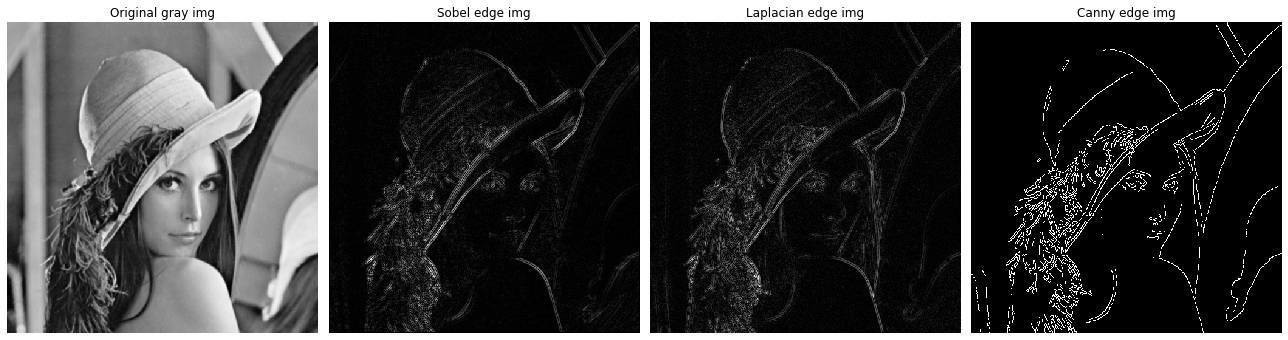

In [61]:
import cv2 as cv
import matplotlib.pyplot as plt

lena = './screenshot/lena.png'
img = cv.imread(lena)

img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) # 转换为灰度图
img_g = cv.GaussianBlur(img_gray, (3, 3), 0) # 进行高斯滤波平滑

# Sobel 算子边缘检测
sobel_result = cv.Sobel(img_g, cv.CV_16S, 1, 1)
sobel_show = cv.convertScaleAbs(sobel_result)

# Laplacian 算子边缘检测
laplacian_result = cv.Laplacian(img_g, cv.CV_16S)
laplacian_show = cv.convertScaleAbs(laplacian_result)

# Canny 算子边缘检测
canny_result = cv.Canny(img_g, 100, 200)
canny_show = cv.convertScaleAbs(canny_result)

# 数据准备
res_list = [img_g, sobel_show, laplacian_show, canny_show]
title = ['Original gray img', 'Sobel edge img', 'Laplacian edge img', 'Canny edge img']

# 交互操作模式
plt.ion()
plt.figure(figsize=(18, 5))

# 作图比较
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(res_list[i], cmap='gray')
    plt.axis('off')
    plt.title(title[i])

plt.tight_layout()  # 自动调整子图结构参数
plt.show()
plt.pause(5)
plt.close()

根据结果进行相关比较:
1. Sobel算子只能基本检测出轮廓边缘，效果不太理想
2. Laplace算子存在明显问题, 采用二次导数的原因，对应边缘形成了2条线，而非一条线，很多地方没有处理不好，如眼睛，鼻子，嘴巴
3. Canny算子虽然有一部分存在断裂，但处理的则比较好

### **三、通过演示图片计算灰度直方图，进一步使用大津算法进行分割，并比较分析分割结果**

In [64]:
# 函数封装
def img_hist_otsu_show(img_path):
    import cv2 as cv
    import matplotlib.pyplot as plt

    # 图片加载和灰度处理
    filename = img_path
    img = cv.imread(filename)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # --------------------- 计算灰度直方图 ---------------------

    # 计算灰度直方图
    img_hist = cv.calcHist([img_gray], [0], None, [256], [0, 256])

    # -------------------- 大津算法进行分割 --------------------

    # 图像预处理
    # _, pic = cv.threshold(img_gray, 0, 255,cv.THRESH_BINARY | cv.THRESH_OTSU) # 此处比较简单的处理，方式之一
    img_gauss = cv.GaussianBlur(img_gray, (5, 5), 0)  # 高斯滤波
    _, gray_OTSU_pic = cv.threshold(img_gauss, 125, 255, cv.THRESH_OTSU)  # 大津算法阈值分割
    element_pic = cv.getStructuringElement(cv.MORPH_CROSS, (3, 3))  # 数学形态学滤波
    pic = cv.morphologyEx(gray_OTSU_pic, cv.MORPH_OPEN, element_pic)  # 开运算滤波
    
    # 数据准备
    img_index = [img, img_hist, pic]
    img_title = ['Source_Img', 'Hist_Img', 'Gray_Otsu_Img']

    # 交互操作模式
    plt.ion()

    for i in range(3):
        plt.subplot(221+i)
        if i == 1 :
            # 显示灰度直方图
            plt.plot(img_index[i])
        else:
            # 显示图片
            plt.imshow(img_index[i])
            plt.axis('off')
        plt.title(img_title[i])
        
    # 自动调整子图结构参数
    plt.tight_layout()
    plt.show()
    plt.pause(3)
    plt.close()

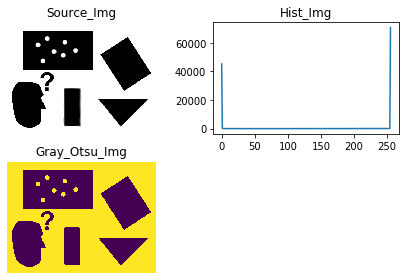

In [65]:
img_hist_otsu_show('./screenshot/pic1.png')

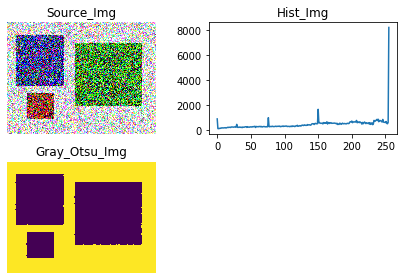

In [56]:
img_hist_otsu_show('./screenshot/pic2.png')

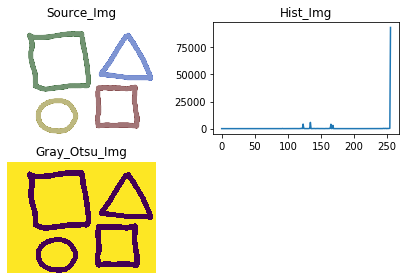

In [57]:
img_hist_otsu_show('./screenshot/pic3.png')

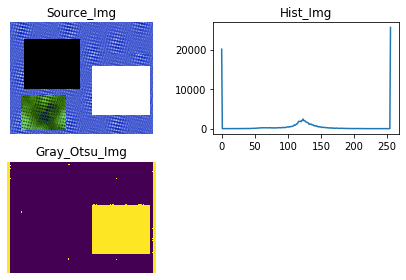

In [58]:
img_hist_otsu_show('./screenshot/pic4.png')

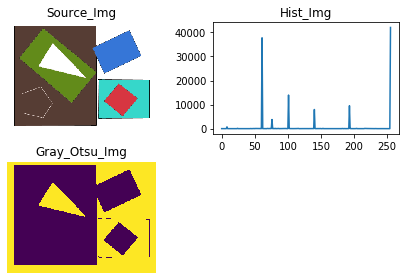

In [59]:
img_hist_otsu_show('./screenshot/pic5.png')

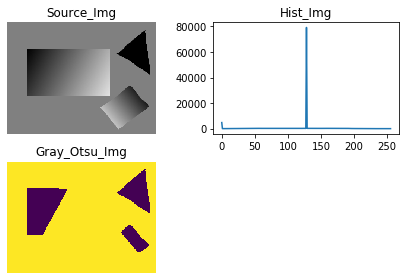

In [60]:
img_hist_otsu_show('./screenshot/pic6.png')

比较分割结果和总结：
1. 大津算法是一类全局阈值化算法，它的阈值选取是针对整个图像的效果来取的
2. 当图像中灰度值发生渐变，或目标表面光照比较复杂，往往得不到太好的效果
3. 大津算法对图像渐变的图像分割效果不佳
4. 大津算法是最常用的一类灰度阈值自动选取方式，目标是令类间方差最大

### **四、分割各米粒，计算各区域(米粒)的面积、长度等信息，进一步计算面积、长度的均值及方差，分析落在3sigma范围内米粒的数量。**

rice area 95  :  48.5
rice length 95 : 14.212670403551895
rice area 94  :  112.5
rice length 94 : 22.80350850198276
rice area 93  :  170.0
rice length 93 : 27.313000567495326
rice area 92  :  2.0
rice length 92 : 4.47213595499958
rice area 91  :  11.0
rice length 91 : 8.06225774829855
rice area 90  :  103.0
rice length 90 : 22.20360331117452
rice area 89  :  164.5
rice length 89 : 28.319604517012593
rice area 88  :  34.0
rice length 88 : 11.661903789690601
rice area 87  :  76.0
rice length 87 : 17.46424919657298
rice area 86  :  102.0
rice length 86 : 23.259406699226016
rice area 85  :  179.0
rice length 85 : 30.870698080866262
rice area 84  :  124.5
rice length 84 : 25.238858928247925
rice area 83  :  160.0
rice length 83 : 29.410882339705484
rice area 82  :  169.5
rice length 82 : 28.0178514522438
rice area 81  :  189.0
rice length 81 : 30.528675044947494
rice area 80  :  168.0
rice length 80 : 29.154759474226502
rice area 79  :  376.0
rice length 79 : 47.885279575251516
rice area 78

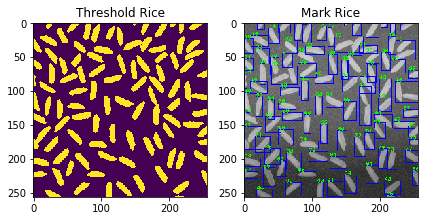

In [71]:
import cv2 as cv
import matplotlib.pyplot as plt
import copy
import numpy as np
import math

filename = './screenshot/rice.png'
image = cv.imread(filename)
areaThreshold = 1000 # 用于去噪的边界值

# 彩色转换灰度，因为我们看到的图像在windows下的表示通常是彩色的
# 在windows下，不管我们看到的是灰度还是彩色的，大多数下它本质是一个三通道的彩色图
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
# 使用大津算法对灰度图像进行自动阈值化，图像中可能会存在一些噪声，同时有一些米粒可能粘贴在一起
# _, bw = cv.threshold(gray, 0, 0xff, cv.THRESH_OTSU) # 效果不是很好
bw = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 101, 1)  # 局部大津算法

# 创建形态学运算结构元素
element = cv.getStructuringElement(cv.MORPH_CROSS, (3,3))
# 使用数学形态学的开运算，减少噪声和米粒的粘连
bw = cv.morphologyEx(bw, cv.MORPH_OPEN, element)

# 为了对图像进行分割，首先对结果进行一次拷贝
seg = copy.deepcopy(bw)
# 使用findContours得到分割后各个区域对应的轮廓集合 cnts
bin, cnts, hier = cv.findContours(seg, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# 个数统计初始化
count = 0
# 建立面积与长度集合
area_list = []
length_list = []

# 对所有轮廓进行循环
for i in range(len(cnts), 0, -1):
    # 得到当前轮廓
    c = cnts[i-1]
    # 计算轮廓对应的面积
    area = cv.contourArea(c)
    # 小于10的当做噪声，不去记入最终米粒，可能是噪声，不满足我们的条件，areaThreshold这个参数可在实际中根据米粒的大小来调节
    if area > areaThreshold:
        continue
    count = count + 1
    area_list.append(area)
    # 计算周长
    circumference = cv.arcLength(c, closed=1)
    # 得到区域轮廓对应的包围矩形
    x, y, w, h = cv.boundingRect(c)
    # 计算矩形框内米粒长度
    length = math.sqrt(w ** 2 + h ** 2)
    length_list.append(length)
    # 在原始图像上用带颜色的方框画出包围矩形
    cv.rectangle(image, (x,y), (x+w, y+h), (0, 0, 0xff), 1)
    # 标记米粒序号
    cv.putText(image, str(count), (x, y), cv.FONT_HERSHEY_PLAIN, 0.5, (0, 0xff, 0))
    # 最后打印出这个米粒区域对应的面积
    print("rice area", i, " : ", area)
    print('rice length', i, ':', length)

print()
# 这里是分割线
print('-' * 20 + ' 分割线 ' + '-' * 20)
print()

# 面积、长度的均值
average_area = np.mean(area_list)
average_length = np.mean(length_list)
# 面积、长度的方差
variance_area = np.var(area_list)
variance_length = np.var(length_list)
# 面积、长度的标准差
sd_area = np.std(area_list)
sd_length = np.std(length_list)

# 统计落在3σ区域内的米粒个数，这里有两个方面：面积和长度
area_3s = 0
length_3s = 0
for i in range(count):
    if abs((area_list[i] - average_area) / sd_area) < 3:
        area_3s += 1
    if abs((length_list[i] - average_length) / sd_length) < 3:
        length_3s += 1

# 输出结果
print('rice number: ', count)
print('average area: ', average_area)
print('average length: ', average_length)
print('variance area:', variance_area)
print('variance length:', variance_length)
print('area_3sigma: ', area_3s)
print('length_3sigma: ', length_3s)

# --------------- 输出图像 开始 ---------------

# 交互操作模式
plt.ion()
# 数据准备
pic_list = [bw, image]
pic_title = ['Threshold Rice', 'Mark Rice']

for i in range(2):
    plt.subplot(121 + i)
    plt.imshow(pic_list[i])
    plt.title(pic_title[i])

plt.tight_layout()  # 自动调整子图结构参数
plt.show()
plt.pause(5)
plt.close()

# --------------- 输出图像 结束 ---------------

### **五、使用棋盘格及自选风景图像，分别使用SIFT、FAST及ORB算子检测角点，并比较分析检测结果。(可选) 使用Harris角点检测算子检测棋盘格，并与上述结果比较。**

In [77]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

# 加载图片
imageL = cv.imread('./screenshot/left01.jpg')
imageR = cv.imread('./screenshot/right01.jpg')

# 图片预处理：灰度处理
imageL_gray = cv.cvtColor(imageL, cv.COLOR_BGR2GRAY)
imageR_gray = cv.cvtColor(imageR, cv.COLOR_BGR2GRAY)

# 交互操作模式 用于画图
plt.ion()
plt.figure(figsize=(27, 9))

# 画图函数
def plot_img(imgList, titleList):
    for i in range(len(imgList)):
        plt.subplot(221 + i)
        plt.imshow(imgList[i])
        plt.title(titleList[i])
        plt.axis('off')
        '''
        # 下面设置同：plt.axis('off')
        # plt.xticks([])
        # plt.yticks([])
        '''

    plt.tight_layout()  # 自动调整子图结构参数
    plt.show()
    plt.pause(15)
    plt.close()

def sift_test():
    '''SIFT算子检测角点'''
    # 设定Hessian阈值
    minHessian = 1000
    # 创建Surf算子对象
    detector = cv.xfeatures2d.SURF_create(minHessian)
    descriptor = cv.xfeatures2d.SURF_create()
    # 检测特征点
    kpL = detector.detect(imageL_gray)
    kpR = detector.detect(imageR_gray)
    # 提取特征点描述子
    kpL, des1 = descriptor.compute(imageL_gray, kpL)
    kpR, des2 = descriptor.compute(imageR_gray, kpR)
    # 特征点作图
    imageL_p = cv.drawKeypoints(imageL, kpL, imageL, color=(0, 0, 255), flags=0)
    imageR_p = cv.drawKeypoints(imageR, kpR, imageR, color=(0, 0, 255), flags=0)
    # 创建描述子匹配对象
    matcher = cv.DescriptorMatcher_create('BruteForce')
    # 特征点匹配
    matches = matcher.match(des1, des2)

    image_match = cv.drawMatches(imageL, kpL, imageR, kpR, matches, None)

    # 开始绘图
    plot_img([image_match, imageL_p, imageR_p],['image_match', 'imageL_p', 'imageR_p'])

def fast_test():
    '''FAST算法'''
    # 创建FAST算子对象
    fast = cv.FastFeatureDetector_create(40)
    # 检测特征点
    kpL = fast.detect(imageL_gray)
    kpR = fast.detect(imageR_gray)
    # FAST9-16检测--Brisk算法
    br = cv.BRISK_create()
    # 提取特征点描述子
    kpL, des1 = br.compute(imageL_gray, kpL)
    kpR, des2 = br.compute(imageR_gray, kpR)
    # 标记特征点
    imageL_p = cv.drawKeypoints(imageL, kpL, imageL, color=(0, 0, 255), flags=0)
    imageR_p = cv.drawKeypoints(imageR, kpR, imageR, color=(0, 0, 255), flags=0)
    # 创建描述子匹配对象
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    # 描述子匹配
    matcher = bf.match(des1, des2)
    image_match = cv.drawMatches(imageL, kpL, imageR, kpR, matcher, None)

    # 开始绘图
    plot_img([image_match, imageL_p, imageR_p], ['image_match', 'imageL_p', 'imageR_p'])

def orb_test():
    ''' ORB算法 '''
    # 创建ORB算子对象
    orb = cv.ORB_create()
    # 检测特征点
    kpL = orb.detect(imageL_gray, None)
    kpR = orb.detect(imageR_gray, None)
    # 提取特征点描述子
    kpL, des1 = orb.compute(imageL_gray, kpL)
    kpR, des2 = orb.compute(imageR_gray, kpR)
    # 标记特征点
    imageL_p = cv.drawKeypoints(imageL, kpL, imageL, color=(0, 0, 255), flags=0)
    imageR_p = cv.drawKeypoints(imageR, kpR, imageR, color=(0, 0, 255), flags=0)
    # 创建描述子匹配对象
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    # 描述子匹配
    matcher = bf.match(des1, des2)
    image_match = cv.drawMatches(imageL, kpL, imageR, kpR, matcher, None)

    # 开始绘图
    plot_img([image_match, imageL_p, imageR_p], ['image_match', 'imageL_p', 'imageR_p'])

def harris_test():
    # Harris角点检测
    image = cv.imread('./screenshot/left01.jpg')
    # image = cv.imread('chessboard.png') # 这个图片不适合这里
    #找到Harris角点
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # 输入图像必须是float32，最后一个参数在0.04 到0.06 之间
    gray = np.float32(gray)
    dst = cv.cornerHarris(gray, 2, 3, 0.04)
    dst = cv.dilate(dst, None)
    # 图像阈值化
    ret, dst = cv.threshold(dst, 0.01 * dst.max(), 255, 0)
    dst = np.uint8(dst)
    # 找到重心
    ret, labels, stats, centroids = cv.connectedComponentsWithStats(dst)
    # 定义迭代次数(超过迭代次数或达到设定收敛阈值时停止)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    # 亚像素角点检测
    corners = cv.cornerSubPix(gray, np.float32(centroids), (5, 5), (-1, -1), criteria)
    # 返回角点
    # 绘制
    res = np.hstack((centroids, corners))
    res = np.int0(res)
    image[res[:, 1], res[:, 0]] = [0, 0, 255]
    image[res[:, 3], res[:, 2]] = [0, 255, 0]

    # 开始绘图
    plot_img([image],['Harris Coner results'])


<Figure size 1944x648 with 0 Axes>

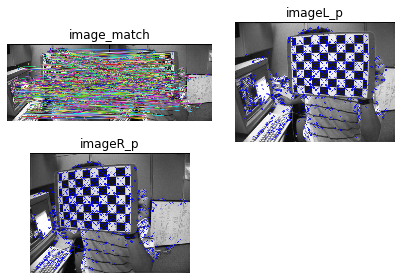

In [78]:
sift_test() # SIFT检测

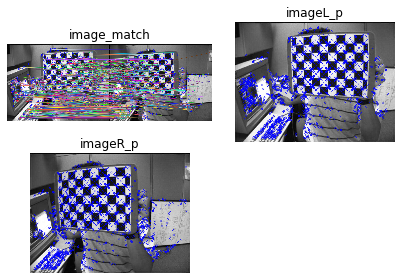

In [79]:
fast_test() # FAST检测

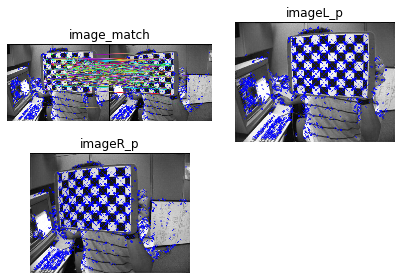

In [80]:
orb_test() # ORB检测

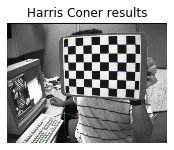

In [ ]:
harris_test() # Harris检测

**比较**
1. SIFT算子的特征点信息最丰富，匹配点也最多，匹配错误也较多
2. FAST算子速度较快，对键盘匹配较好
3. ORB算子对棋盘匹配程度较好。
4. Harris角点检测基本可以准确检测相对应的角点。